<h4> W/m^2 Model </h4>

this module is to be used in conjunction with the solar data provided from the Data_collection.ipynb and API_calls.ipynp modules and fed into the Dashboard.ipynp module to predict the current and historic data Watt per meter squared production of a user defined location.

In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error, explained_variance_score
import sklearn.preprocessing as preprocessing
 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import pickle

In [15]:
data = pd.read_csv('Final_df.csv', sep= "\t")

In [16]:
print(data.shape)
data.head(5)

(2563478, 8)


,Zenith Angle [degrees],Azimuth Angle [degrees],Latitude [deg],Longitude [deg],Temp [deg C],Minutes,Direct Irradiance [W/m^2],Global Irradiance [W/m^2]
0,124.102,358.791,39.75685,104.62025,18.08,0.0,-1.000000,-1.0
1,124.105,359.082,39.75685,104.62025,18.14,1.0,-1.000000,-1.0
2,124.108,359.372,39.75685,104.62025,18.17,2.0,-0.712310,-1.0
3,124.109,359.659,39.75685,104.62025,18.20,3.0,-0.396415,-1.0
4,124.110,359.952,39.75685,104.62025,18.21,4.0,-0.371638,-1.0


In [18]:
day_data = data[(data['Minutes'] > 350) & (data['Minutes'] < 2000)]
day_data.shape

(1724754, 8)

In [5]:
data.describe()

,Zenith Angle [degrees],Azimuth Angle [degrees],Latitude [deg],Longitude [deg],Temp [deg C],Minutes,Direct Irradiance [W/m^2],Global Irradiance [W/m^2]
count,2.563478e+06,2.563478e+06,2.563478e+06,2.563478e+06,2.563478e+06,2.563478e+06,2.563478e+06,2.563478e+06
mean,8.959049e+01,1.799902e+02,3.466432e+01,1.215564e+02,1.495563e+01,1.179271e+03,2.106644e+02,2.022111e+02
std,3.875137e+01,1.000177e+02,7.350955e+00,2.028059e+01,1.076150e+01,6.923992e+02,3.501749e+02,2.987023e+02
min,6.900000e-02,0.000000e+00,2.076685e+01,7.621600e+01,-2.888000e+01,0.000000e+00,-1.000000e+00,-1.000000e+00
25%,5.895377e+01,8.950000e+01,3.541861e+01,1.080883e+02,8.750000e+00,5.590000e+02,0.000000e+00,-1.000000e+00
50%,8.930000e+01,1.799275e+02,3.610700e+01,1.151425e+02,1.606000e+01,1.159000e+03,0.000000e+00,3.293565e+00
75%,1.203495e+02,2.705000e+02,3.975685e+01,1.240800e+02,2.223000e+01,1.759000e+03,3.931140e+02,3.415623e+02
max,1.799000e+02,3.600000e+02,4.087600e+01,1.569229e+02,4.399000e+01,2.359000e+03,2.224100e+03,1.495270e+03


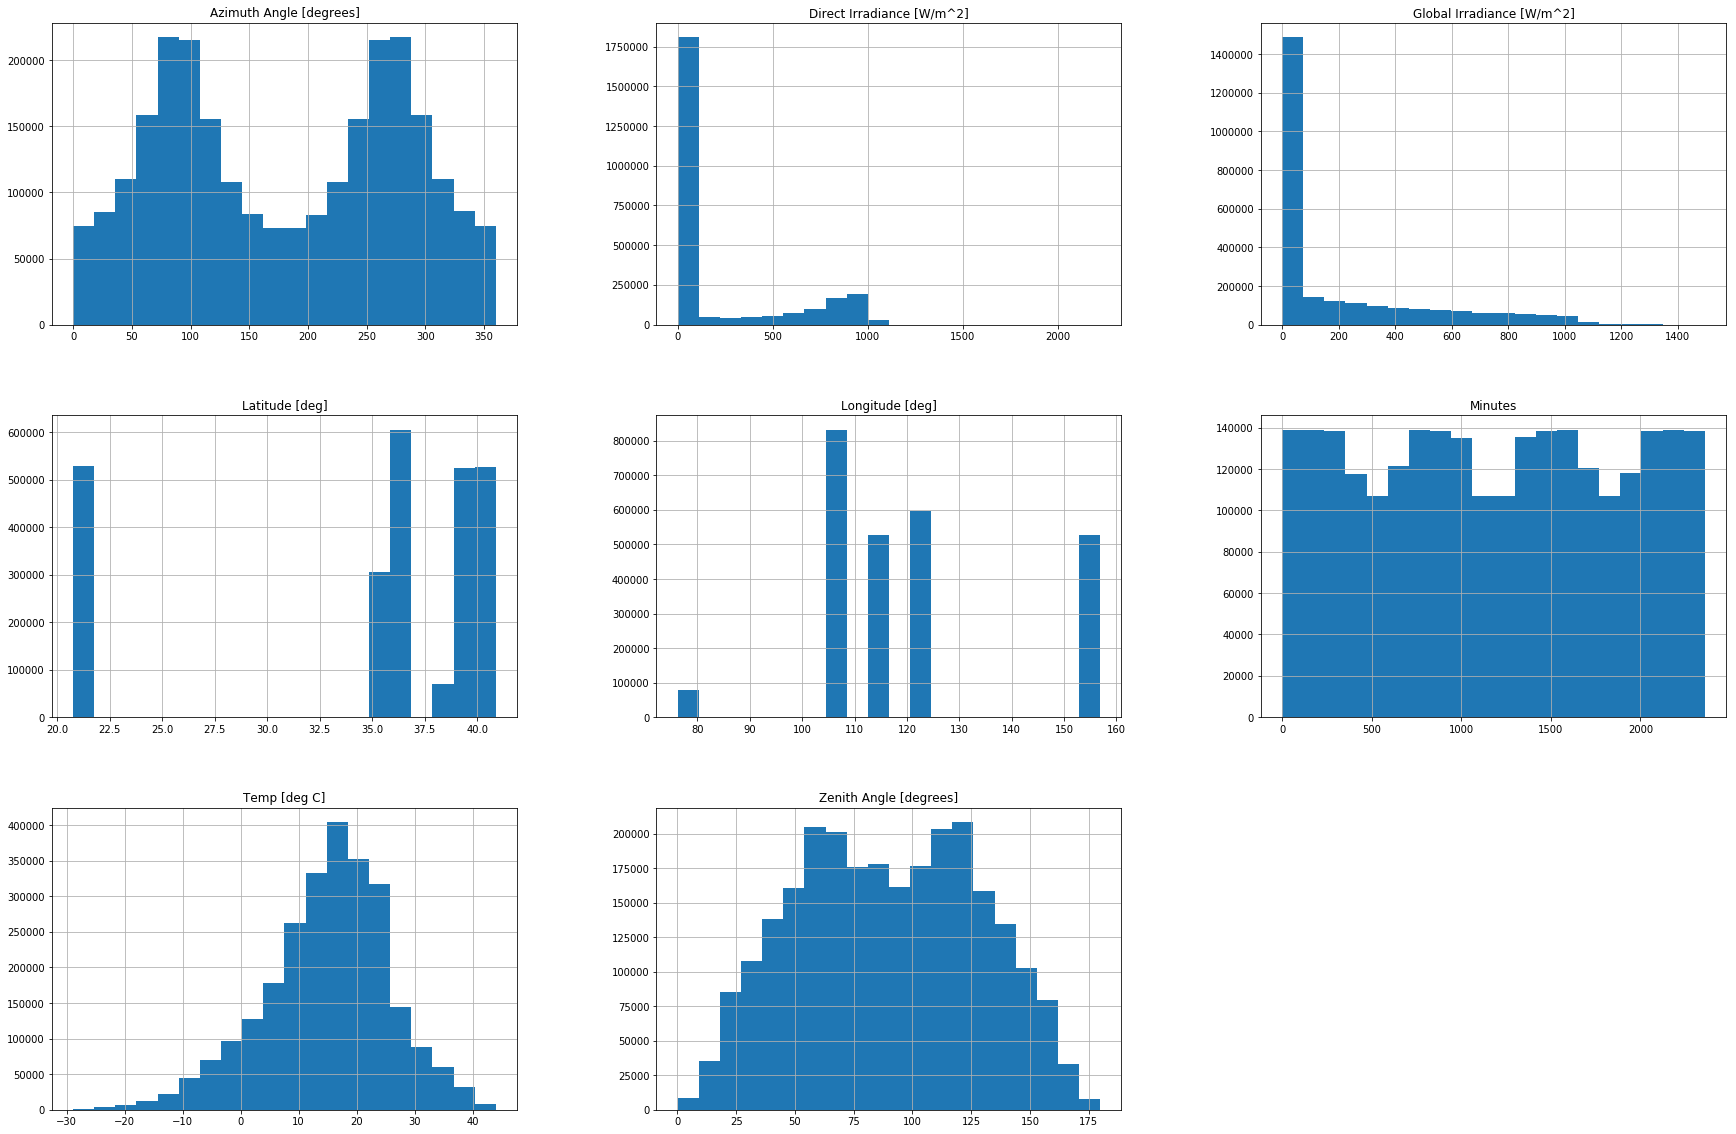

In [12]:
feat = data.loc[:, 'Zenith Angle [degrees]':'Global Irradiance [W/m^2]']
feat.hist(figsize=(30,20), bins=20);

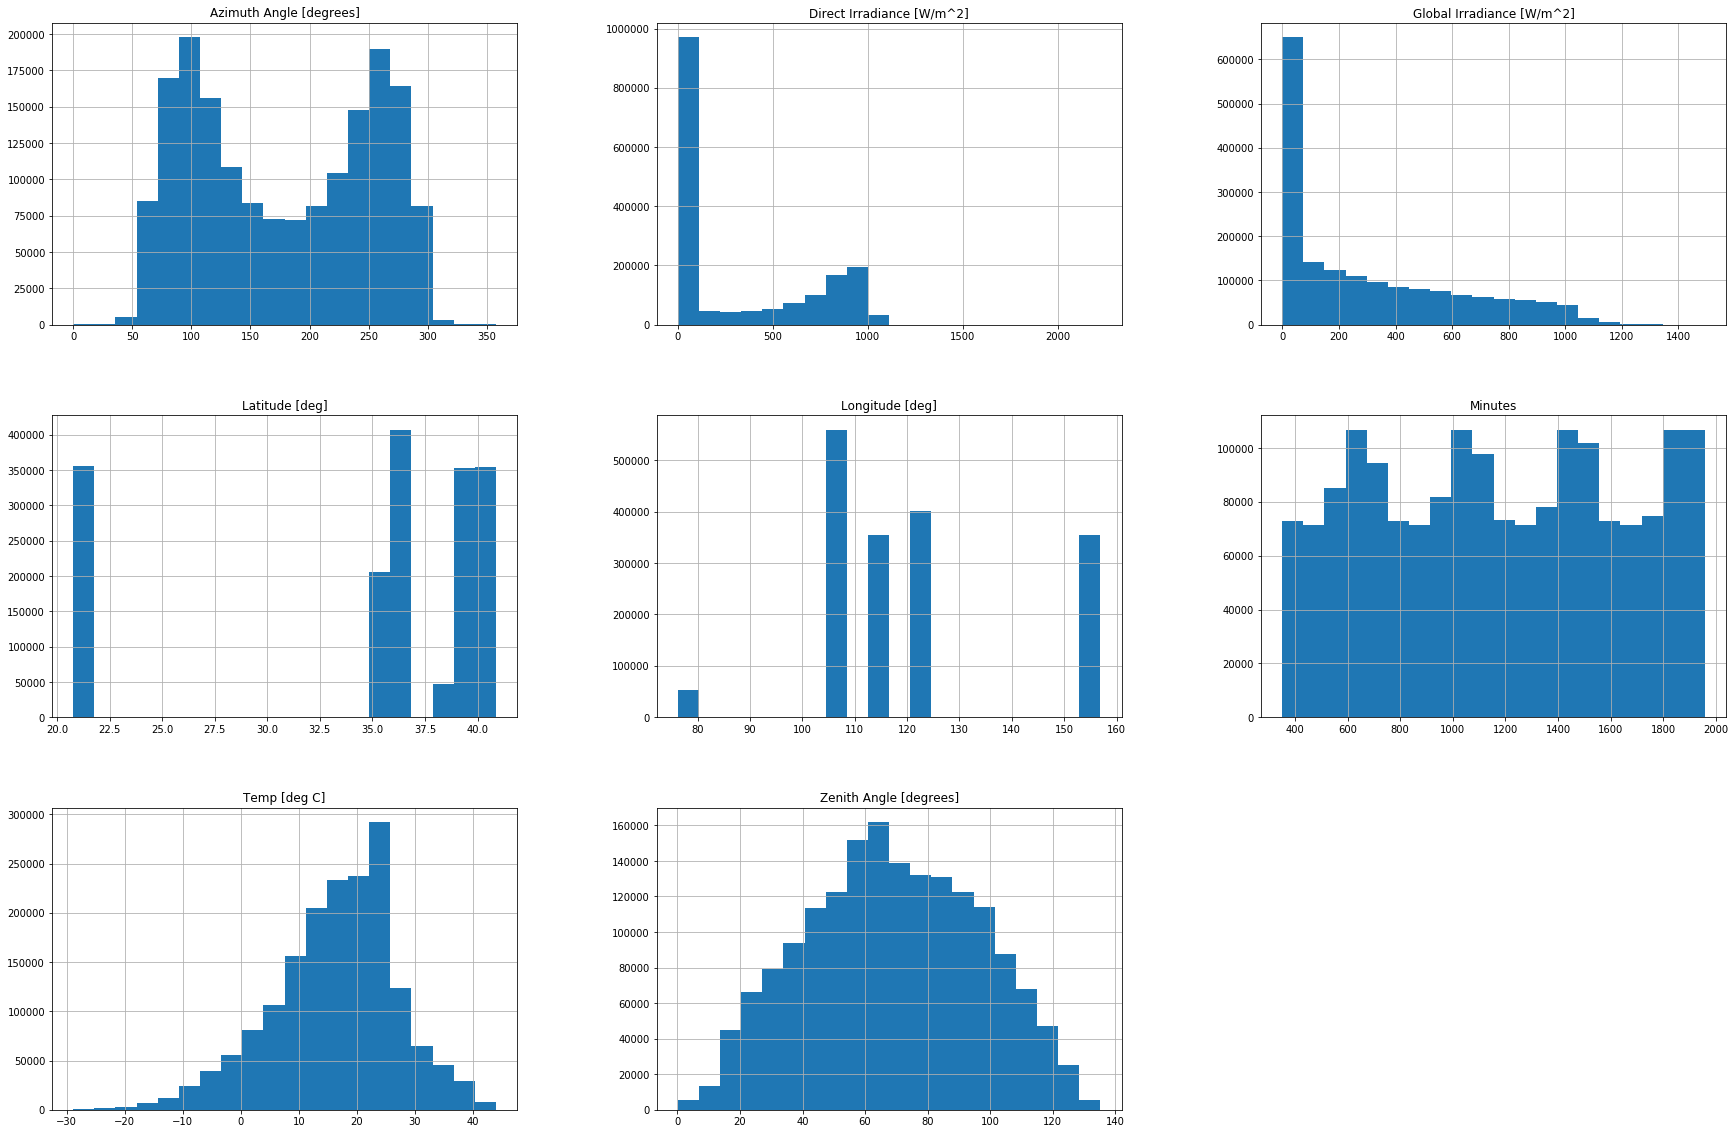

In [7]:
feat = day_data.loc[:, 'Zenith Angle [degrees]':'Global Irradiance [W/m^2]']
feat.hist(figsize=(30,20), bins=20);

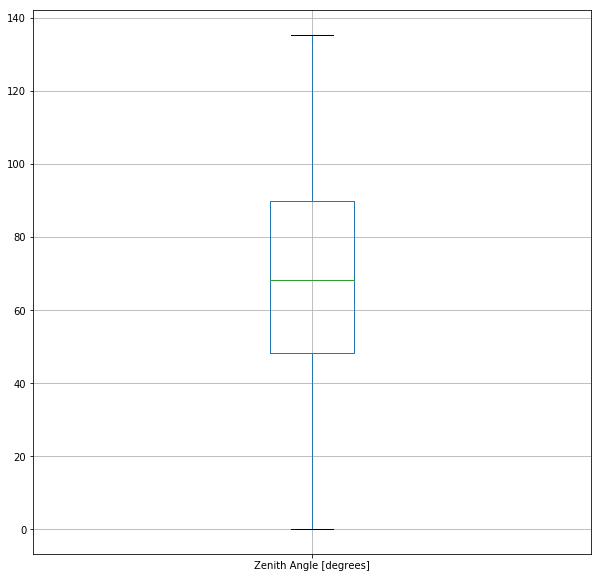

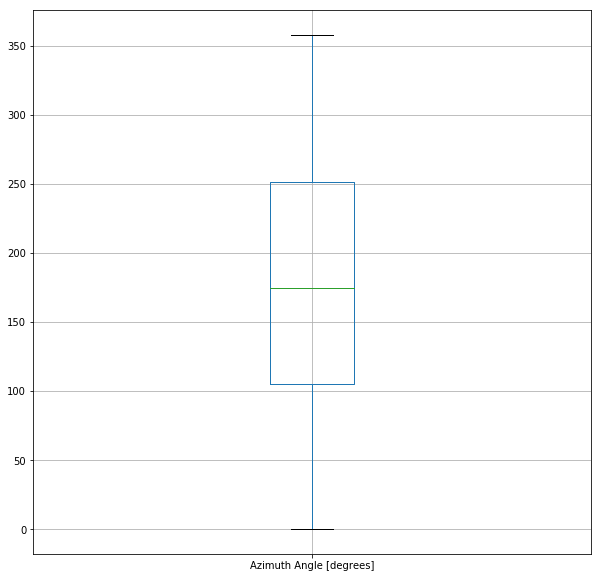

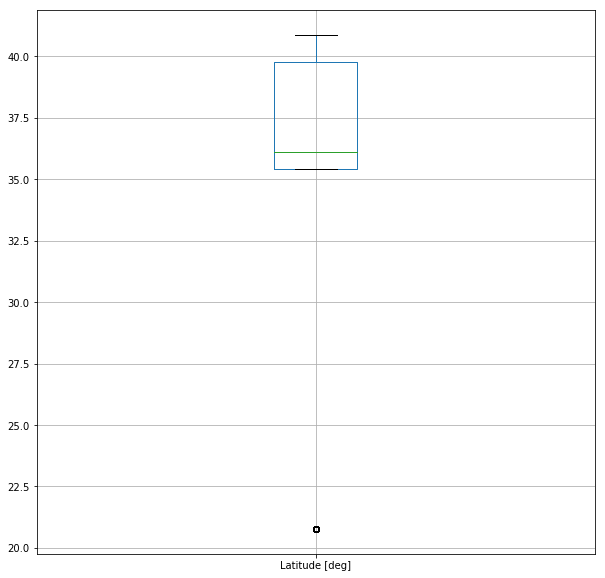

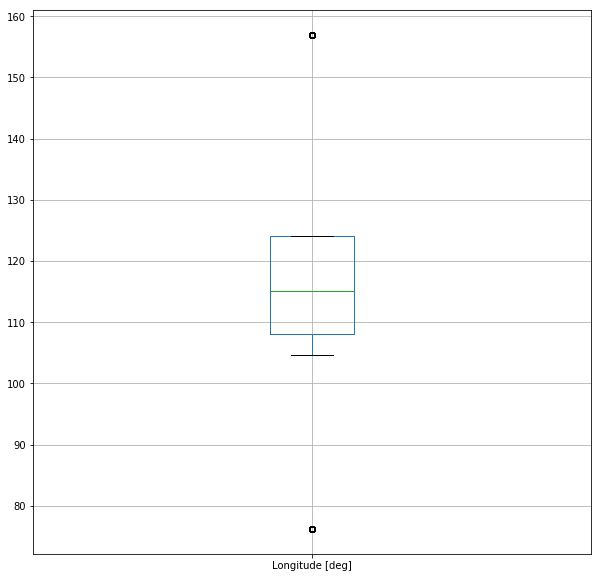

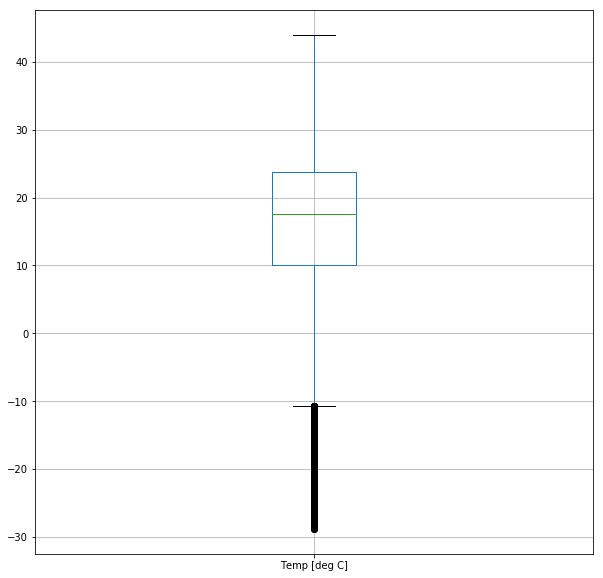

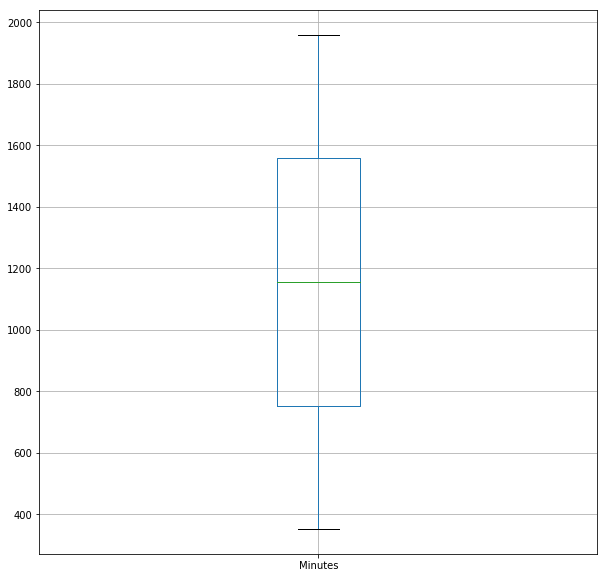

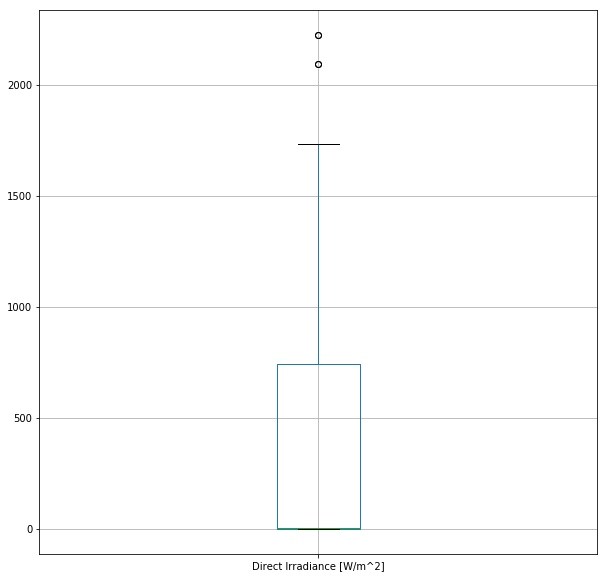

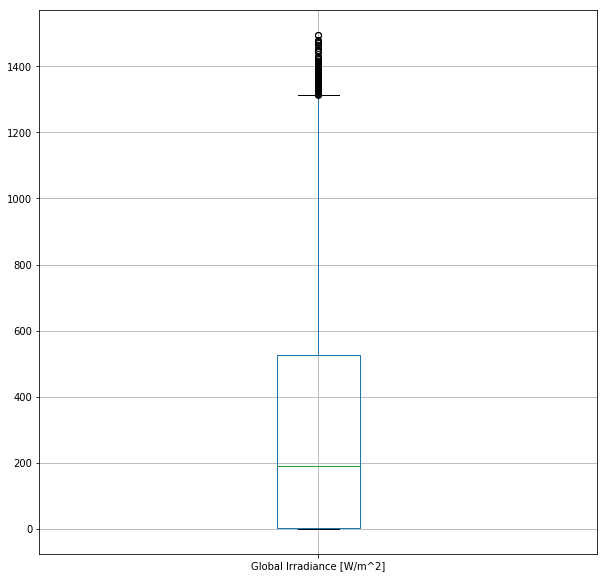

In [8]:
for f in feat:
    pd.DataFrame(day_data[f]).boxplot(figsize=(10,10));
    plt.show();

AttributeError: 'AxesSubplot' object has no attribute 'savefig'

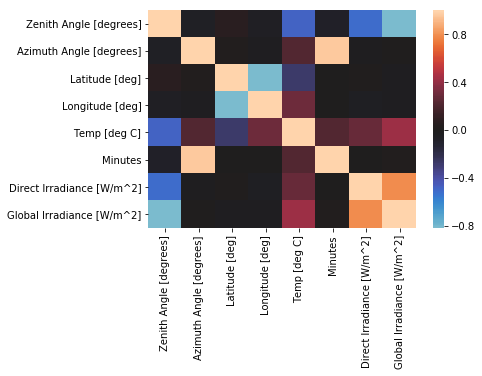

In [10]:
import seaborn as sns
heat = sns.heatmap(feat.corr(), center=0);
heat.savefig('heatmap.png')

<h3> 1st Iteration: Basic Decision Tree </h3>

In [76]:
# On the bar and box plots it looks like we have extreme outliers.  
# I don't think this is too unreasonable for a set 2m strong and will leave them in.
print(data.shape)
data['Global Irradiance [W/m^2]'].sort_values(ascending=False).head(10)

(2563478, 8)


1807876    1495.27
2320221    1493.66
413924     1480.49
2282816    1476.59
989938     1473.50
1956180    1470.26
1856908    1463.73
925166     1455.90
1770474    1450.86
1721565    1448.87
Name: Global Irradiance [W/m^2], dtype: float64

In [9]:
cols

Index(['Zenith Angle [degrees]', 'Azimuth Angle [degrees]', 'Latitude [deg]',
       'Longitude [deg]', 'Temp [deg C]', 'Minutes',
       'Direct Irradiance [W/m^2]', 'Global Irradiance [W/m^2]'],
      dtype='object')

In [9]:
'''
defining subsets of data for alternate models
'''

# No Times

no_times = day_data.drop(['Minutes', 'Direct Irradiance [W/m^2]'],
                        axis = 1)

# No Temps

no_temps = data.drop(['Temp [deg C]', 'Direct Irradiance [W/m^2]'],
                    axis = 1)

# Solar Angles Only

solar = data['Zenith Angle [degrees]']
solar['Azimuth Angle [degrees]'] = data['Zenith Angle [degrees]']

In [10]:
'''
Two possible target variables:
Direct Irradiance should have a stronger correlation with peak sunlight hours
Global Irradiance should account for more features in the eco system.
I might want to engineer a model that can account for both.  I might want to run either and choose the better predictor.
'''

# Global
X_g = data.drop(['Global Irradiance [W/m^2]', 'Direct Irradiance [W/m^2]'],axis = 1)
y_g = data['Global Irradiance [W/m^2]']

# Direct
X_d = data.drop(['Global Irradiance [W/m^2]', 'Direct Irradiance [W/m^2]'],axis = 1)
y_d = data['Direct Irradiance [W/m^2]']

targets = {'global': [X_g, y_g], 'direct': [X_d, y_d]}
targets.keys()

dict_keys(['global', 'direct'])

In [14]:
# Day Global
X_d = day_data.drop(['Global Irradiance [W/m^2]', 'Direct Irradiance [W/m^2]'],axis = 1)
y_d = day_data['Global Irradiance [W/m^2]']

# No Times Global
X_nt = no_times.drop(['Global Irradiance [W/m^2]'], axis = 1)
y_nt = no_times['Global Irradiance [W/m^2]']

# no temps
X_d_nT = X_d.drop(['Temp [deg C]'], axis = 1)
y_d_nT = y_d

NameError: name 'no_times' is not defined

<h3> Preprocessing options </h3>

multiple variables will be set and tested in order to try different versions of the models.  Several iterations will be run to see which fits the test data best and which works best with real life data as second test.

In [40]:
minmax = preprocessing.MinMaxScaler()
X_norm = minmax.fit_transform(X_nt)
scaler = minmax.fit(targets['global'][0])

In [6]:
x_tr, x_ts, y_tr, y_ts = train_test_split(X_norm, targets['global'][1], test_size= 0.3)
print(x_tr.shape, y_tr.shape)
print(x_ts.shape, y_ts.shape)

(1794434, 6) (1794434,)
(769044, 6) (769044,)


<h4> Standard Scaler </h4>

In [107]:
ss = preprocessing.StandardScaler()
X_scale = ss.fit_transform(X_d)
ss_scaler = ss.fit(X_d)
x_tr, x_ts, y_tr, y_ts = train_test_split(X_scale, y_d, test_size= 0.3)

In [16]:
reg_tree = DecisionTreeRegressor()

In [17]:
%%time

reg_tree.fit(x_tr, y_tr)

Wall time: 21.4 s


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [18]:
print(f'Coefficent of determination {reg_tree.score(x_ts, y_ts)}')

Coefficent of determination 0.8804379117325533


In [19]:
targets['global'][0].columns

Index(['Zenith Angle [degrees]', 'Azimuth Angle [degrees]', 'Latitude [deg]',
       'Longitude [deg]', 'Temp [deg C]', 'Minutes'],
      dtype='object')

In [20]:
reg_tree.feature_importances_

array([0.81626838, 0.05041357, 0.0063045 , 0.02186492, 0.07651319,
       0.02863544])

In [22]:
y_pred = reg_tree.predict(x_ts)
np.corrcoef(y_pred, y_ts)

array([[1.        , 0.94015641],
       [0.94015641, 1.        ]])

In [34]:
# memorizing training data because max_depth is set too high
def cv_mse_plot(x, y, max_depth = 5, num = 15):
    from sklearn.metrics import mean_squared_error
    train_err = []
    test_err = []
    for i in range(num):
        x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size= 0.3)
        reg_tree = DecisionTreeRegressor(max_depth=max_depth)
        reg_tree.fit(x_tr, y_tr)
        y_hat_train = reg_tree.predict(x_tr)
        y_hat_test = reg_tree.predict(x_ts)
        train_err.append(mean_squared_error(y_tr, y_hat_train))
        test_err.append(mean_squared_error(y_ts, y_hat_test))
    plt.scatter(list(range(num)), train_err, label='Training Error')
    plt.title(f'Error over {num} instances')
    plt.scatter(list(range(num)), test_err, label='Testing Error')
    plt.legend();
    return reg_tree

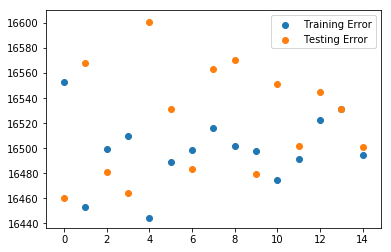

In [36]:
# Plot the results
global_5 = cv_mse_plot(X_norm, targets['global'][1])

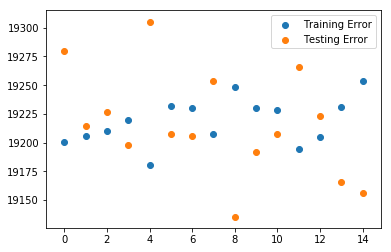

In [37]:
golobal_3_depth = cv_mse_plot(X_norm, targets['global'][1], max_depth = 3)

In [38]:
# golobal_3_depth = cv_mse_plot(X_norm, targets['global'][1], max_depth = 3)

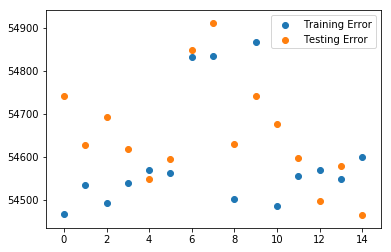

In [39]:
minmax = preprocessing.MinMaxScaler()
X_norm = minmax.fit_transform(targets['direct'][0])
direct_5_depth = cv_mse_plot(X_norm, targets['direct'][1])

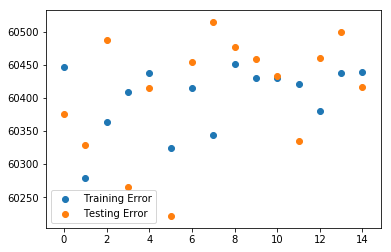

In [40]:
direct_3_depth = cv_mse_plot(X_norm, targets['direct'][1], max_depth = 3)

The global irradiadiance looks to be fit better than the direct irradiance. <br><b> global irradiance will be used for the remainder of this module. </b>


In [46]:
def cv_mse_scoring(model, x, y, num_cv = 10):
    '''
    takes several runs from the supplied data and model and averages the error
    '''
    from sklearn.model_selection import cross_val_score
    x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size= 0.3)
    y_pred = model.predict(x_ts)
    
    cv_results = np.mean(cross_val_score(model, x_tr, y_tr, cv=num_cv, scoring="neg_mean_squared_error"))
    cv_test_results = np.mean(cross_val_score(model, y_pred.reshape(-1, 1), y_ts, cv=num_cv, scoring="neg_mean_squared_error"))
    
    ###MSE is the squared W/m^2 error
    from math import sqrt
    pos_MSE = -1*cv_results
    Median_Error = sqrt(pos_MSE)
    print(f'Average error of prediction model vs training data: {round(Median_Error, 2)}W/m^2')

    pos_MSE_test = -1*cv_test_results
    Median_Error = sqrt(pos_MSE_test)
    print(f'Average error of prediction model vs test data: {round(Median_Error, 2)}W/m^2')

In [47]:
cv_mse_scoring(global_5, X_norm, targets['global'][1])

Average error of prediction model vs training data: 128.53W/m^2
Average error of prediction model vs test data: 128.59W/m^2


### 2nd Iteration : Decision Tree + Hyperparameters

In [57]:
reg_tree2 = DecisionTreeRegressor()


param_grid = {
    "criterion": ["mse"],
    "max_depth": [3, 4, 5, 6, 7],
    "min_samples_split": [1.0, 5, 10, 20]
}

gs_tree = GridSearchCV(reg_tree2, param_grid, cv=3)

In [58]:
gs_tree.fit(x_tr, y_tr)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['mse'], 'max_depth': [2, 3, 4, 5, 6], 'min_samples_split': [1.0, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [59]:
print(f'Coefficent of determination {gs_tree.best_score_}')

0.8237713458379637

In [60]:
gs_tree.best_params_

{'criterion': 'mse', 'max_depth': 6, 'min_samples_split': 5}

We take a bit of a hit on the accuracy as to be expected since our initial model was overfitting.  Now that we know that our max_depth should be around 5 We will try more powerful models and validate again later.

<h3> Random Forest </h3>

In [71]:
forest_reg = RandomForestRegressor()

param_grid = {
    "criterion": ["mse"],
    "max_depth" : [5,6,7,8],
    "max_features" : ['auto'],
    "max_leaf_nodes" : [None],
    "min_impurity_decrease" : [0.0],
    "min_impurity_split" : [None],
    "min_samples_leaf" : [2,1],
    "min_samples_split" : [4,6],
    "min_weight_fraction_leaf" : [0.0],
    "n_estimators" : [75,100],
}

grid_forest = GridSearchCV(forest_reg, param_grid, cv=3, n_jobs=5, verbose=2, scoring='r2')

In [72]:
%%time
grid_forest.fit(x_tr, y_tr)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed: 57.0min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed: 321.5min
[Parallel(n_jobs=5)]: Done 216 out of 216 | elapsed: 501.6min finished


Wall time: 8h 29min 24s


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'criterion': ['mse'], 'max_depth': [4, 5, 6, 7], 'max_features': ['auto'], 'max_leaf_nodes': [None], 'min_impurity_decrease': [0.0], 'min_impurity_split': [None], 'min_samples_leaf': [2, 1], 'min_samples_split': [4, 6, 8], 'min_weight_fraction_leaf': [0.0], 'n_estimators': [75, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [73]:
# save the model to disk
filename = 'random_forest.sav'
pickle.dump(grid_forest, open(filename, 'wb'))

In [75]:
best_parameters = grid_forest.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_forest.predict(x_tr)
val_preds = grid_forest.predict(x_ts)

# Metrics
# r2_score, mean_absolute_error, explained_variance_score
print(f'Explained variance {explained_variance_score(y_ts, val_preds)}')

Grid Search found the following optimal parameters: 
criterion: 'mse'
max_depth: 7
max_features: 'auto'
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_impurity_split: None
min_samples_leaf: 1
min_samples_split: 4
min_weight_fraction_leaf: 0.0
n_estimators: 75
Explained variance 0.8340060672209564


In [76]:
r2 = r2_score(y_ts, val_preds)
r2

0.8340060672095044

In [82]:
print(f'The average difference between true values and predicted values is {mean_absolute_error(y_ts, val_preds)}')

The average difference between true values and predicted values is 62.036736115005695


<h3> AdaBoost </h3>

In [85]:
Ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=7),
                          n_estimators=75) # mirror best params from other model

Ada_reg.fit(x_tr, y_tr)

# Predict
y_hat = Ada_reg.predict(x_ts)

In [86]:
print(f'Explained variance {explained_variance_score(y_ts, y_hat)}')

Explained variance 0.7945267770577392


In [87]:
Ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=100) # mirror best params from other model

Ada_reg.fit(x_tr, y_tr)

# Predict
y_hat = Ada_reg.predict(x_ts)

In [88]:
print(f'Explained variance {explained_variance_score(y_ts, y_hat)}')

Explained variance 0.7915657788726351


AdaBoost doesn't seem to preform very well compared to the previous models

<h3> XGBoost </h3>

In [22]:
import xgboost as xgb

In [10]:
xgb_reg = xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
                 objective='reg:linear', gamma=0, min_child_weight=1, 
                 max_delta_step=0, subsample=1, colsample_bytree=1, 
                 seed=0, missing=None)

['_Booster', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_estimator_type', '_get_param_names', 'apply', 'base_score', 'booster', 'coef_', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'evals_result', 'feature_importances_', 'fit', 'gamma', 'get_booster', 'get_num_boosting_rounds', 'get_params', 'get_xgb_params', 'importance_type', 'intercept_', 'kwargs', 'learning_rate', 'load_model', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'predict', 'random_state', 'reg_alpha', 'reg_lambda', 'save_model', 'scale_pos_weight', 'score', 'seed', 'set_params', 'silent', 'subsample', 'verbosity

In [11]:
xgb_reg.fit(x_tr, y_tr)

C:\Users\Mark\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1, verbosity=1)

In [12]:
val_preds = xgb_reg.predict(x_ts)

In [16]:
print(f'Explained variance {explained_variance_score(y_ts, val_preds)}')
print('')
print(f'The average difference between true values and predicted values is {mean_absolute_error(y_ts, val_preds)}')

Explained variance 0.8388814740360321

The average difference between true values and predicted values is 65.01123788890875


This is close to the results we got after doing a grid search on the random forest model,
it warrents a grid search of it's own.

In [8]:
xgb_grid = xgb.XGBRegressor(objective='reg:linear')
param_grid = {
    "learning_rate": [0.1, 0.2],
    'max_depth': [3,4,5],
    'min_child_weight': [10],
    'subsample': [0.7, 1],
    'n_estimators': [50, 100, 250],
}

grid_xgb = GridSearchCV(xgb_grid, param_grid, scoring='r2', cv=3, n_jobs=4, verbose=2)

In [9]:
%%time
grid_xgb.fit(x_tr, y_tr)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 30.2min
[Parallel(n_jobs=4)]: Done 108 out of 108 | elapsed: 114.2min finished
C:\Users\Mark\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:10:12] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 2h 1min 39s


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [3, 4, 5], 'min_child_weight': [10], 'subsample': [0.7, 1], 'n_estimators': [50, 100, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=2)

In [10]:
best_parameters = grid_xgb.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_xgb.predict(x_tr)
val_preds = grid_xgb.predict(x_ts)

Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 5
min_child_weight: 10
n_estimators: 250
subsample: 1


In [13]:
print(f'Explained variance {explained_variance_score(y_ts, val_preds)}')
print('')
print(f'The average difference between true values and predicted values is {mean_absolute_error(y_ts, val_preds)}')

Explained variance 0.8580126115154864

The average difference between true values and predicted values is 56.71531492077808


In [11]:
# save the model to disk
filename = 'xgboost.sav'
pickle.dump(grid_xgb, open(filename, 'wb'))

<h3> 2nd Run XGBoost </h3>

In [19]:
xgb_grid = xgb.XGBRegressor(objective='reg:linear')
param_grid = {
    "learning_rate": [0.1, 0.2],
    'max_depth': [4,5,6],
    'min_child_weight': [10],
    'subsample': [1, 2],
    'n_estimators': [100, 250, 300],
}

grid_xgb2 = GridSearchCV(xgb_grid, param_grid, scoring='r2', cv=3, n_jobs=4, verbose=2)

In [30]:
clf_xgb = xgb.XGBRegressor(objective = 'reg:linear')
param_dist = {'n_estimators': [100, 250, 300],
              'learning_rate': [0.2, 0.3],
              'subsample': [0.6, 0.9],
              'max_depth': [4, 5, 6, 7],
              'min_child_weight': [4, 6, 10]
             }

clf = GridSearchCV(clf_xgb,
             param_dist,
             cv = 3,
             scoring = 'r2', 
             error_score = 0, 
             verbose = 3, 
             n_jobs = -1)

In [31]:
%%time
clf.fit(x_tr, y_tr)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 173.2min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 492.5min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 830.0min finished
C:\Users\Mark\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:14:40] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 14h 2min 40s


GridSearchCV(cv=3, error_score=0,
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 250, 300], 'learning_rate': [0.2, 0.3], 'subsample': [0.6, 0.9], 'max_depth': [4, 5, 6, 7], 'min_child_weight': [4, 6, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=3)

In [33]:
best_parameters = clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = clf.predict(x_tr)
val_preds = clf.predict(x_ts)

Grid Search found the following optimal parameters: 
learning_rate: 0.3
max_depth: 7
min_child_weight: 10
n_estimators: 300
subsample: 0.9


Grid Search found the following optimal parameters: <br>
learning_rate: 0.3 <br>
max_depth: 7 <br> 
min_child_weight: 10 <br>
n_estimators: 300 <br>
subsample: 0.9 <br>

In [34]:
print(f'Explained variance {explained_variance_score(y_ts, val_preds)}')
print('')
print(f'The average difference between true values and predicted values is {mean_absolute_error(y_ts, val_preds)}')

Explained variance 0.8730574440770459

The average difference between true values and predicted values is 52.59745000632475


In [52]:
# save the model to disk
filename = 'finalized_model.pkl'
pickle.dump(clf, open(filename, 'wb'))

In [53]:
# save scaler to disk
scaler_file = 'scaler.pkl'
pickle.dump(scaler, open(scaler_file, 'wb'))

<h4> Standard Scaler XGBoost on Day Data </h4>

setting train test variables to standard scaler preprocessing, see code above.

In [80]:
ss = preprocessing.StandardScaler()
X_d_scale = ss.fit_transform(X_d)
ss_d_scaler = ss.fit(X_d)
x_tr, x_ts, y_tr, y_ts = train_test_split(X_d_scale, y_d, test_size= 0.3)

In [108]:
xgb_day = xgb.XGBRegressor(objective = 'reg:linear')
day_param_dist = {'n_estimators': [300],
              'learning_rate': [0.3],
              'subsample': [1, 1.5],
              'max_depth': [6, 7],
              'min_child_weight': [10, 12]
             }

day_clf = GridSearchCV(xgb_day,
             day_param_dist,
             cv = 3,
             scoring = 'r2', 
             error_score = 0, 
             verbose = 3, 
             n_jobs = -1)

In [109]:
%%time
day_clf.fit(x_tr, y_tr)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed: 11.2min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 18.3min finished
C:\Users\Mark\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:30:23] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 23min 19s


GridSearchCV(cv=3, error_score=0,
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [300], 'learning_rate': [0.3], 'subsample': [1, 1.5], 'max_depth': [6, 7], 'min_child_weight': [10, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=3)

In [110]:
best_parameters = ss_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = day_clf.predict(x_tr)
val_preds = day_clf.predict(x_ts)

Grid Search found the following optimal parameters: 
learning_rate: 0.3
max_depth: 7
min_child_weight: 12
n_estimators: 300
subsample: 1


In [111]:
print(f'Explained variance {explained_variance_score(y_ts, val_preds)}')
print('')
print(f'The average difference between true values and predicted values is {mean_absolute_error(y_ts, val_preds)}')

Explained variance 0.7599354200310358

The average difference between true values and predicted values is 105.14412103213962


In [113]:
# save the model to disk
filename = 'day_model.pkl'
pickle.dump(day_clf, open(filename, 'wb'))

# save scaler to disk
scaler_file = 'day_scaler.pkl'
pickle.dump(ss_d_scaler, open(scaler_file, 'wb'))

<h3> Temps might be over fitting... </h3>
here's a try at the most strict subset yet.

In [20]:
ss = preprocessing.StandardScaler()
X_d_scale = ss.fit_transform(X_d_nT)
ss_d_scaler = ss.fit(X_d_nT)
x_tr, x_ts, y_tr, y_ts = train_test_split(X_d_scale, y_d, test_size= 0.3)

In [25]:
xgb_strict = xgb.XGBRegressor(objective = 'reg:squarederror')
strict_param_dist = {'n_estimators': [250, 300],
              'learning_rate': [0.25, 0.3],
              'subsample': [1, 1.5],
              'max_depth': [5, 6, 7],
              'min_child_weight': [10, 12]
             }

strict_clf = GridSearchCV(xgb_strict,
             strict_param_dist,
             cv = 3,
             scoring = 'r2', 
             error_score = 0, 
             verbose = 3, 
             n_jobs = -1)

In [26]:
%%time
strict_clf.fit(x_tr, y_tr)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 77.2min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 103.8min finished
C:\Users\Mark\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Wall time: 1h 51min 6s


GridSearchCV(cv=3, error_score=0,
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [250, 300], 'learning_rate': [0.25, 0.3], 'subsample': [1, 1.5], 'max_depth': [5, 6, 7], 'min_child_weight': [10, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=3)

In [28]:
best_parameters = strict_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = strict_clf.predict(x_tr)
val_preds = strict_clf.predict(x_ts)

Grid Search found the following optimal parameters: 
learning_rate: 0.3
max_depth: 7
min_child_weight: 12
n_estimators: 300
subsample: 1


In [29]:
print(f'Explained variance {explained_variance_score(y_ts, val_preds)}')
print('')
print(f'The average difference between true values and predicted values is {mean_absolute_error(y_ts, val_preds)}')

Explained variance 0.7736780107158592

The average difference between true values and predicted values is 96.21308449342328


<h2> Saving Best </h2>

In [31]:
# save the model to disk
filename = 'strict_model.pkl'
pickle.dump(strict_clf, open(filename, 'wb'))

# save scaler to disk
scaler_file = 'strict_scaler.pkl'
pickle.dump(ss_d_scaler, open(scaler_file, 'wb'))